In [165]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [166]:
raw_dataset = pd.read_csv("tier6.csv")
df = raw_dataset.copy()

In [167]:
df.isna().sum()

id                             0
divsRank                     542
finalRank                   2239
swimmer                      576
swimmerage                   576
school                         0
event                          0
seedTime                     381
divsTime                     542
finalTime                   2239
qualified                      0
year                           0
points                         0
divsSpeed                    542
numRelays                     17
numEvents                     17
gender                         0
distance                       0
stroke                         0
isRelay                        0
divsTimePctOfMean            542
normed_divsTimePctOfMean     542
normed_divsSpeed             542
normed_numRelays              17
normed_numEvents              17
normed_distance                0
clipped_divsRank             542
designation                 3906
dtype: int64

In [168]:
df = dataset.dropna(subset=["divsTime"])
df.isna().sum()

id                             0
divsRank                       0
finalRank                   1579
swimmer                      200
swimmerage                   200
school                         0
event                          0
seedTime                       0
divsTime                       0
finalTime                   1579
qualified                      0
year                           0
points                         0
divsSpeed                      0
numRelays                      0
numEvents                      0
gender                         0
distance                       0
stroke                         0
isRelay                        0
divsTimePctOfMean              0
normed_divsTimePctOfMean       0
normed_divsSpeed               0
normed_numRelays               0
normed_numEvents               0
normed_distance                0
clipped_divsRank               0
designation                 3419
dtype: int64

In [169]:
df = df[["qualified", "isRelay", "clipped_divsRank", "normed_divsSpeed", "normed_divsTimePctOfMean", "stroke", "points"]]

In [170]:
onehot = pd.get_dummies(df["stroke"])
df = df.drop("stroke", axis=1)
df = df.join(onehot)
df.qualified = df.qualified.astype(int)
df.isRelay = df.isRelay.astype(int)


In [171]:
df.dtypes

qualified                     int32
isRelay                       int32
clipped_divsRank            float64
normed_divsSpeed            float64
normed_divsTimePctOfMean    float64
points                        int64
Backstroke                    uint8
Breaststroke                  uint8
Butterfly                     uint8
Freestyle                     uint8
IM                            uint8
Medley                        uint8
dtype: object

In [172]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)
train_labels = train_dataset.pop('points')
test_labels = test_dataset.pop('points')

In [221]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        # layers.Dense(64, activation='tanh'),
        # layers.Dense(64, activation='tanh'),
        # layers.Dense(64, activation='tanh'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
    return model

model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 64)                768       
_________________________________________________________________
dense_74 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_75 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 65        
Total params: 9,153
Trainable params: 9,153
Non-trainable params: 0
_________________________________________________________________


In [222]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[1.1345412 ],
       [1.0893427 ],
       [0.7720199 ],
       [0.87734586],
       [1.224871  ],
       [0.4510124 ],
       [1.196087  ],
       [1.154626  ],
       [1.1792043 ],
       [0.5607625 ]], dtype=float32)

In [223]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
    train_dataset, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[early_stop, PrintDot()])


....................................................................................................
..

In [224]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
97,4.996877,1.127814,4.996876,4.928866,1.154853,4.928865,97
98,4.950280,1.122784,4.950278,4.957881,1.221830,4.957881,98
99,5.027015,1.126367,5.027014,4.688398,1.155618,4.688398,99
100,5.010789,1.122943,5.010788,4.479687,1.036706,4.479687,100
101,5.039506,1.126529,5.039506,4.642228,0.985986,4.642229,101


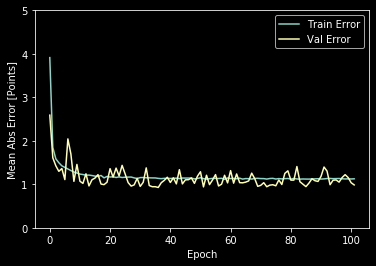

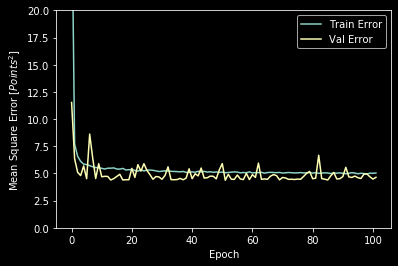

In [225]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Points]')
    plt.plot(hist['epoch'], hist['mae'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Points^2$]')
    plt.plot(hist['epoch'], hist['mse'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)

In [226]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} points".format(mae))

724/724 - 0s - loss: 6.1121 - mae: 1.1447 - mse: 6.1121
Testing set Mean Abs Error:  1.14 points


[]

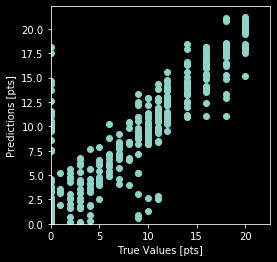

In [227]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [pts]')
plt.ylabel('Predictions [pts]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot()

Text(0, 0.5, 'Count')

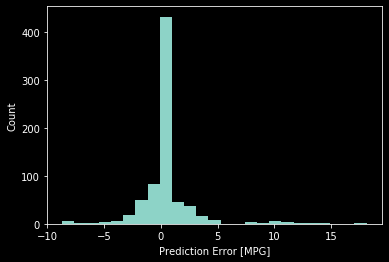

In [228]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")